## Preparar entorno y credenciales

### Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### GEE

In [ ]:
# Instalar geemap (si no está instalado)
!pip install geemap --upgrade

import geemap
import ee
ee.Authenticate()
ee.Initialize(project="ee-freddyvillota")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.2 MB/s eta 0:00:00


## Definir área de estudio (Provincia de Carchi, Ecuador)

In [ ]:
# Cargar colección de nivel 2 (cantones)
ec_provincias = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq("ADM0_NAME", "Ecuador"))

# Obtener los nombres únicos de cantones
provincias_list = ec_provincias.aggregate_array("ADM1_NAME").distinct()
print(provincias_list.getInfo())

['Napo', 'Orellana', 'Guayas', 'Pichincha', 'Santa Elena', 'Santo Domingo de los Tsachilas', 'Azuay', 'Bolivar', 'Canar', 'Carchi', 'Chimborazo', 'Cotopaxi', 'El Oro', 'Esmeraldas', 'Galapagos', 'Imbabura', 'Loja', 'Los Rios', 'Manabi', 'Morona Santiago', 'Pastaza', 'Sucumbios', 'Tungurahua', 'Zamora Chinchipe', 'Zona No Delimitada']


In [ ]:
# Cargar colección de nivel 2 (cantones)
ec_cantones = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2") \
    .filter(ee.Filter.eq("ADM0_NAME", "Ecuador")) \
    .filter(ee.Filter.eq("ADM1_NAME", "Carchi"))

# Obtener los nombres únicos de cantones
cantones_list = ec_cantones.aggregate_array("ADM2_NAME").distinct()
print(cantones_list.getInfo())

['Bolivar', 'Espejo', 'Mira', 'Montufar', 'San Pedro de Huaca', 'Tulcan']


In [ ]:
# Cargar provincia (nivel 1) y filtrar por Carchi
provincias = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq("ADM0_NAME", "Ecuador"))
roi = provincias.filter(ee.Filter.eq("ADM1_NAME", "Carchi"))

## Visualizar PET (FAO-56) en Earth Engine

In [ ]:
import ee
import geemap.foliumap as geemap

# 1) Define ROI de Carchi (nivel 1)
roi = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1") \
    .filter(ee.Filter.eq("ADM0_NAME", "Ecuador")) \
    .filter(ee.Filter.eq("ADM1_NAME", "Carchi"))

# 2) Carga ERA5-Land mensual de 2020
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .filterDate('1981-01-01', '2024-12-31') \
    .select([
        'temperature_2m',
        'dewpoint_temperature_2m',
        'u_component_of_wind_10m',
        'v_component_of_wind_10m',
        'surface_net_solar_radiation',
        'surface_net_thermal_radiation'
    ])

# 3) Función para calcular PET
def calcPet(img):
    # Temperaturas (°C)
    T  = img.select('temperature_2m').subtract(273.15)
    Td = img.select('dewpoint_temperature_2m').subtract(273.15)
    # Radiación neta MJ/m²·día
    Ra = img.select('surface_net_solar_radiation') \
           .add(img.select('surface_net_thermal_radiation')) \
           .divide(1e6)
    # Días en el mes
    date = img.date()
    days = ee.Image.constant(
        date.advance(1, 'month').difference(date, 'day')
    )
    Rn = Ra.divide(days)
    G = ee.Image.constant(0)
    # Saturación y pendiente (Δ)
    es = T.expression(
        '0.6108 * exp(17.27 * T / (T + 237.3))', {'T': T}
    )
    ea = Td.expression(
        '0.6108 * exp(17.27 * Td / (Td + 237.3))', {'Td': Td}
    )
    delta = es.multiply(4098).divide(T.add(237.3).pow(2))
    # Psicométrica γ
    gamma = ee.Image.constant(1.013e-3 * 101.3 / (0.622 * 2.45))
    # Velocidad del viento a 2 m
    u2m = img.select('u_component_of_wind_10m')
    v2m = img.select('v_component_of_wind_10m')
    wind_speed = u2m.pow(2).add(v2m.pow(2)).sqrt() \
        .multiply(4.87) \
        .divide(ee.Number(67.8 * 10 - 5.42).log())
    # Ecuación FAO-56
    pet = delta.multiply(Rn.subtract(G)).multiply(0.408) \
          .add(
            gamma.multiply(900).divide(T.add(273))
                 .multiply(wind_speed)
                 .multiply(es.subtract(ea))
          ) \
          .divide(
            delta.add(
              gamma.multiply(ee.Image.constant(1).add(wind_speed.multiply(0.34)))
            )
          ) \
          .rename('PET')

    return pet.copyProperties(img, img.propertyNames())

# 4) Aplica y recorta enero 2020
petCol = era5.map(calcPet)
pet_registro1 = petCol.filter(ee.Filter.calendarRange(1,1,'month')).first().clip(roi)

# 1) Calcula PET mínimo y máximo sobre el ROI
stats = pet_registro1.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi.geometry(),
    scale=10000,
    bestEffort=True,
    maxPixels=1e9
).getInfo()

pet_min = stats['PET_min']
pet_max = stats['PET_max']
print(f"PET mínimo = {pet_min:.3f} mm/día")
print(f"PET máximo = {pet_max:.3f} mm/día")

# 2) Visualiza usando los rangos dinámicos
vis = {
    'min': pet_min,
    'max': pet_max,
    'palette': ['blue', 'green', 'yellow', 'red']
}

Map = geemap.Map(center=[0.95, -78.4], zoom=8)
Map.addLayer(pet_registro1, vis, 'PET del primer registro identificado')
Map.addLayer(roi.style(
    color='red',
    width=2,
    fillColor='00000000'
), {}, "Carchi - Borde rojo")
Map

/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for ECMWF/ERA5_LAND/MONTHLY! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY

  warnings.warn(warning, category=DeprecationWarning)


PET mínimo = 0.092 mm/día
PET máximo = 0.235 mm/día


## Extraer series mensuales a pandas y calcular PET

### 💧 Cálculo de PET con Penman–Monteith (FAO-56) usando ERA5-Land

En este bloque describimos cómo se implementa la ecuación de Penman–Monteith (FAO-56) paso a paso para calcular la PET mensual dentro de Google Earth Engine:

1. **Conversión de temperaturas a °C**  
   - `T  = temperature_2m - 273.15`  
   - `Td = dewpoint_temperature_2m - 273.15`  

2. **Radiación neta media diaria (Rₙ)**  
   - Suma de radiación solar y térmica neta (J m⁻² mes) → MJ m⁻² dividendo por 1e6.  
   - Divide por el número de días del mes para obtener MJ m⁻² día:
   ```js
   Ra = (surface_net_solar_radiation + surface_net_thermal_radiation) / 1e6;
   days = date.advance(1, 'month').difference(date, 'day');
   Rn = Ra.divide(days);
Pendiente de presión de vapor (Δ)

Calcula presión de vapor de saturación:



```
eₛ = 0.6108 · exp(17.27·T/(T+237.3))
```


Deriva Δ:

```
Δ = 4098·eₛ / (T + 237.3)²
```
Constante psicrométrica (γ)

Basada en presión atmosférica estándar (101.3 kPa):

```
γ = (1.013·10⁻³ · 101.3) / (0.622 · 2.45)
```
Velocidad del viento a 2 m (u₂)

Combina componentes a 10 m:

```
u = sqrt(u₁₀² + v₁₀²)
```
Convierte a 2 m según FAO-56:

```
u₂ = u · 4.87 / ln(67.8·10 – 5.42)
```
Ecuación FAO-56

```
PET = [0.408·Δ·(Rₙ–0) + γ·(900/(T+273))·u₂·(eₛ–eₐ)]
      / [Δ + γ·(1 + 0.34·u₂)]
Donde G (calor del suelo) se asume cero para promedios mensuales.

El resultado se expresa en mm/día.
```

Visualización

Filtrar por mes (p.ej. enero) y recortar al polígono de Carchi.

Añadir al mapa con una paleta de colores para resaltar variaciones de PET.

Este cálculo se implementa íntegramente en JavaScript/Python vía la API de Earth Engine y se dibuja con geemap en Colab.


In [ ]:
import pandas as pd

# 1) Recalcular colección PET para varios años
era5_pet = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .filterDate('1981-01-01', '2024-12-31') \
    .select([
        'temperature_2m', 'dewpoint_temperature_2m',
        'u_component_of_wind_10m', 'v_component_of_wind_10m',
        'surface_net_solar_radiation', 'surface_net_thermal_radiation'
    ]) \
    .map(calcPet)

# 2) Extraer promedio mensual de PET sobre el ROI
def img_to_feature(img):
    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi.geometry(),
        scale=10000,
        bestEffort=True,
        maxPixels=1e9
    )
    return ee.Feature(None, stats.set('date', img.date().format('YYYY-MM')))

# 3) Convertir a lista de features
pet_features = era5_pet.map(img_to_feature).getInfo()['features']

# 4) Convertir a DataFrame de pandas
rows = []
for f in pet_features:
    props = f['properties']
    rows.append({
        'date': props['date'],
        'PET_mm_day': props['PET']
    })

df_pet = pd.DataFrame(rows)
df_pet['date'] = pd.to_datetime(df_pet['date'])
df_pet = df_pet.sort_values('date').reset_index(drop=True)

# 5) Agregar año, mes y PET mensual (asumiendo 30.4 días promedio)
df_pet['year'] = df_pet['date'].dt.year
df_pet['month'] = df_pet['date'].dt.month
df_pet['PET_mm_month'] = df_pet['PET_mm_day'] * df_pet['date'].dt.days_in_month

df_pet.head()

,date,PET_mm_day,year,month,PET_mm_month
0,1981-01-01,0.146402,1981,1,4.538457
1,1981-02-01,0.175214,1981,2,4.906004
2,1981-03-01,0.120592,1981,3,3.738337
3,1981-04-01,0.150655,1981,4,4.519645
4,1981-05-01,0.152015,1981,5,4.712460


<ipython-input-8-566b46be0838>:9: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_pet = df_pet['PET_mm_month'].resample('A').mean()


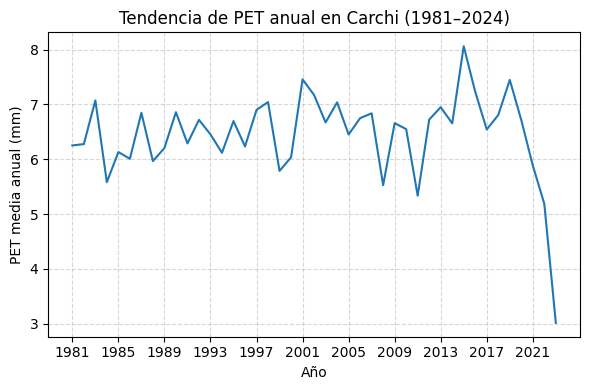

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Prepara la columna de fecha
df_pet['date'] = pd.to_datetime(df_pet[['year', 'month']].assign(day=1))
df_pet = df_pet.set_index('date')

# 2) Calcula la PET anual como promedio de los 12 meses
annual_pet = df_pet['PET_mm_month'].resample('A').mean()
years = annual_pet.index.year

# 3) Dibuja la serie
plt.figure(figsize=(6, 4))
plt.plot(years, annual_pet.values)
plt.xlabel('Año')
plt.ylabel('PET media anual (mm)')
plt.title('Tendencia de PET anual en Carchi (1981–2024)')

# Mostrar solo cada 4 años en el eje X
step = 4
plt.xticks(years[::step])

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

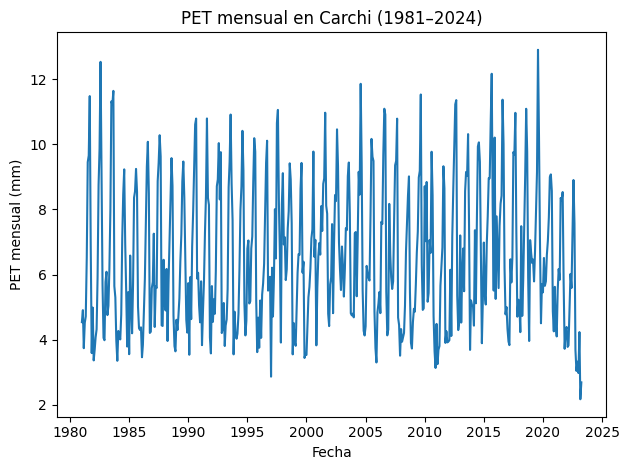

In [ ]:
# Serie mensual
monthly_pet = df_pet['PET_mm_month']
plt.figure()
plt.plot(monthly_pet.index, monthly_pet.values)
plt.xlabel('Fecha')
plt.ylabel('PET mensual (mm)')
plt.title('PET mensual en Carchi (1981–2024)')
plt.tight_layout()
plt.show()

### Extraer precipitación mensual (mm) desde Earth Engine

In [ ]:
import ee
import pandas as pd

# 1) Define ROI y período
roi = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1") \
    .filter(ee.Filter.eq("ADM0_NAME", "Ecuador")) \
    .filter(ee.Filter.eq("ADM1_NAME", "Carchi"))

era5 = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .filterDate('1981-01-01', '2024-12-31') \
    .select([
        'total_precipitation',          # m
        'temperature_2m',               # K
        'dewpoint_temperature_2m',      # K
        'u_component_of_wind_10m',      # m/s
        'v_component_of_wind_10m',      # m/s
        'surface_net_solar_radiation',  # J/m²
        'surface_net_thermal_radiation' # J/m²
    ])

# 2) Función para convertir cada imagen en un Feature con variables climáticas
def img_to_feature(img):
    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi.geometry(),
        scale=10000,
        bestEffort=True,
        maxPixels=1e9
    )
    return ee.Feature(None, stats.set('date', img.date().format('YYYY-MM')))

# 3) Aplicar la función
features = era5.map(img_to_feature).getInfo()['features']

# 4) Convertir a DataFrame
rows = []
for f in features:
    props = f['properties']
    rows.append({
        'date': props['date'],
        'precip_mm': float(props['total_precipitation']) * 1000,        # m → mm
        'temp_c': float(props['temperature_2m']) - 273.15,              # K → °C
        'wind_u': float(props['u_component_of_wind_10m']),
        'wind_v': float(props['v_component_of_wind_10m']),
        'solar_rad': float(props['surface_net_solar_radiation']) / 1e6 # J/m² → MJ/m²
       })

df_vars = pd.DataFrame(rows)
df_vars['date'] = pd.to_datetime(df_vars['date'])
df_vars = df_vars.sort_values('date').reset_index(drop=True)

# Resultado
df_vars.head()

,date,precip_mm,temp_c,wind_u,wind_v,solar_rad
0,1981-01-01,17.320967,13.820871,0.085281,-0.137070,12.716649
1,1981-02-01,21.017205,14.046861,-0.126304,0.013116,12.303850
2,1981-03-01,19.203109,14.441554,0.124552,-0.137545,12.726321
3,1981-04-01,17.264962,14.619948,0.059594,-0.078826,13.345170
4,1981-05-01,17.055039,14.424726,-0.047208,-0.076885,12.216821


## Calcular balance hídrico mensual

In [ ]:
# 1) Unir los dos DataFrames por fecha
df = pd.merge(df_pet, df_vars, on='date')

# 2) Calcular el balance hídrico: precipitación menos PET
df['balance_mm'] = df['precip_mm'] - df['PET_mm_month']

# 3) Vista previa
df[['date', 'precip_mm', 'PET_mm_month', 'balance_mm']].head()

,date,precip_mm,PET_mm_month,balance_mm
0,1981-01-01,17.320967,4.538457,12.782510
1,1981-02-01,21.017205,4.906004,16.111201
2,1981-03-01,19.203109,3.738337,15.464772
3,1981-04-01,17.264962,4.519645,12.745317
4,1981-05-01,17.055039,4.712460,12.342579


**Exportar a drive**

In [ ]:
# # Definir ruta y nombre del archivo
# export_path = '/content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/MIAA_taller02/data/df_balanceH_historico.csv'

# # Guardar como CSV
# df.to_csv(export_path, index=False)

# print("✅ Archivo exportado correctamente a:")
# print(export_path)

### Visualizar el balance hídrico mensual

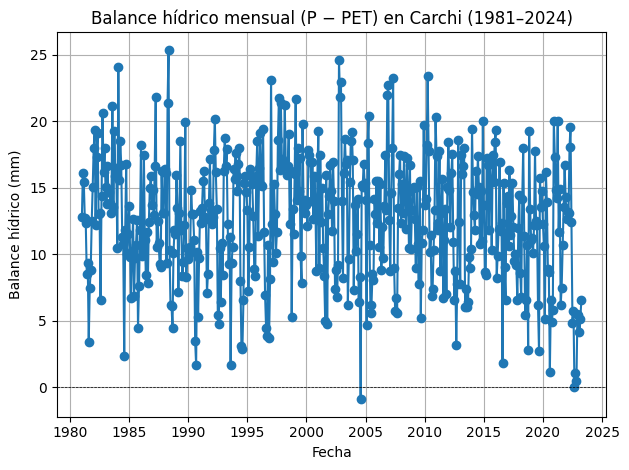

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df['date'], df['balance_mm'], marker='o')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Balance hídrico (mm)')
plt.title('Balance hídrico mensual (P − PET) en Carchi (1981–2024)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 1) Volvemos a cargar PET y P en las mismas fechas
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .filterDate('2020-01-01', '2024-12-31')

# 2) Calculamos la PET con Penman–Monteith (ya tienes esta función definida)
petCol = era5.map(calcPet)

# 3) Extraemos la precipitación (en mm)
precipCol = era5.select('total_precipitation') \
    .map(lambda img: img.multiply(1000).rename('precip_mm') \
        .copyProperties(img, img.propertyNames()))

# 4) Unimos ambas colecciones por fecha y restamos: P - PET
def compute_balance(img):
    date = img.date()
    pet = petCol.filterDate(date, date.advance(1, 'month')).first()
    precip = precipCol.filterDate(date, date.advance(1, 'month')).first()
    balance = precip.subtract(pet).rename('balance_mm')
    return balance.set('system:time_start', img.get('system:time_start'))

balanceCol = precipCol.map(compute_balance)

# 5) Seleccionamos un mes para visualizar (ej. enero 2020)
balanceJan2020 = balanceCol.filter(ee.Filter.calendarRange(1,1,'month')) \
                           .first().clip(roi)

# 6) Estimar valores para visualización
stats = balanceJan2020.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi.geometry(),
    scale=10000,
    bestEffort=True,
    maxPixels=1e9
).getInfo()

bal_min = stats['balance_mm_min']
bal_max = stats['balance_mm_max']
print(f"Balance mínimo: {bal_min:.2f} mm")
print(f"Balance máximo: {bal_max:.2f} mm")

# 7) Mostrar en el mapa
vis = {
    'min': bal_min,
    'max': bal_max,
    'palette': ['red', 'yellow', 'lightgreen', 'green', 'blue']
}

Map = geemap.Map(center=[0.95, -78.4], zoom=8)
Map.addLayer(balanceJan2020, vis, 'Balance hídrico enero 2020')
Map.addLayer(roi.style(color='black', width=2, fillColor='00000000'), {}, 'Carchi')
Map

Balance mínimo: 4.06 mm
Balance máximo: 51.77 mm


In [ ]:
def mostrar_balance_hidrico(year, month):
    """
    Visualiza el mapa suavizado del balance hídrico mensual (precipitación - PET)
    en la región de Carchi usando datos ERA5-Land y PET calculado con Penman–Monteith.

    Parámetros:
    - year (int): Año (ej. 2020)
    - month (int): Mes (1–12)
    """
    # 1) Cargar ERA5 y calcular PET
    era5 = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
        .filterDate(f"{year}-{month:02d}-01", f"{year}-{month:02d}-28")

    petCol = era5.map(calcPet)

    # 2) Cargar precipitación en mm
    precipCol = era5.select('total_precipitation') \
        .map(lambda img: img.multiply(1000).rename('precip_mm') \
             .copyProperties(img, img.propertyNames()))

    # 3) Obtener la imagen del mes
    pet = petCol.first()
    pr = precipCol.first()
    balance = pr.subtract(pet).rename('balance_mm').clip(roi)

    # 4) Suavizado visual con bicubic
    balance_smooth = balance.resample('bicubic')

    # 5) Obtener min y max para visualizar
    stats = balance.reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=roi.geometry(),
        scale=10000,
        bestEffort=True
    ).getInfo()

    vmin = stats['balance_mm_min']
    vmax = stats['balance_mm_max']
    print(f"🟢 Visualizando balance hídrico para {year}-{month:02d}")
    print(f"Balance mínimo: {vmin:.2f} mm | máximo: {vmax:.2f} mm")

    vis = {
        'min': vmin,
        'max': vmax,
        'palette': ['red', 'yellow', 'lightgreen', 'green', 'blue']
    }

    Map = geemap.Map(center=[0.95, -78.4], zoom=8)
    Map.addLayer(balance_smooth, vis, f'Balance hídrico {year}-{month:02d}')
    Map.addLayer(roi.style(color='black', width=2, fillColor='00000000'), {}, 'Carchi')
    return Map


In [ ]:
mostrar_balance_hidrico(2018, 3)

🟢 Visualizando balance hídrico para 2018-03
Balance mínimo: 1.61 mm | máximo: 49.53 mm
